In [1]:
!pip install chardet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.4/199.4 kB 4.3 MB/s eta 0:00:00a 0:00:01


In [2]:
import os
os.environ['TOKENIZERS_PARALLELISM'] = 'false'
import warnings
warnings.filterwarnings('ignore')
import json
import chardet
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import random
from tqdm import tqdm
from PIL import Image
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset,DataLoader
from torch.nn.utils.rnn import pad_sequence
from sklearn.metrics import f1_score,classification_report,accuracy_score

from transformers import AutoTokenizer
from transformers import AutoModel
from torchvision.models import resnet50
from torchvision import transforms
from torch import optim
from torch.optim import AdamW

In [3]:
#random seed
seed_value = 123
np.random.seed(seed_value)
random.seed(seed_value)
os.environ['PYTHONHASHSEED']=str(seed_value)

torch.manual_seed(seed_value)
torch.cuda.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

torch.backends.cudnn.deterministic = True

#device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [4]:
#超参
class config:
     # 根目录
    root_path = '/kaggle/input/multimodal-emotion/'
    data_dir = os.path.join(root_path, 'multimodal/data')
    train_data_path = os.path.join(root_path, 'multimodal/train.json')
    test_data_path = os.path.join(root_path, 'multimodal/test.json')
    output_path = '/kaggle/working/'
    output_test_path = os.path.join(output_path, 'test.txt')
    load_model_path = None

    # 一般超参
    epoch = 20
    learning_rate = 3e-5
    weight_decay = 0
    num_labels = 3
    loss_weight = [1.68, 9.3, 3.36]

    # Fuse相关
    fuse_model_type = 'OTE'
    only = None
    middle_hidden_size = 64
    attention_nhead = 8
    attention_dropout = 0.4
    fuse_dropout = 0.5
    out_hidden_size = 128
    
    # BERT相关
    fixed_text_model_params = False
    # bert_name = 'bert-base-uncased'
    bert_name = 'roberta-base'
    bert_learning_rate = 1e-4
    bert_dropout = 0.4

    # ResNet相关
    fixed_img_model_params = False
    image_size = 224
    fixed_image_model_params = True
    resnet_learning_rate = 1e-4
    resnet_dropout = 0.4
    img_hidden_seq = 64


    # Dataloader params
    checkout_params = {'batch_size': 4, 'shuffle': False}
    train_params = {'batch_size': 32, 'shuffle': True, 'num_workers': 1}
    val_params = {'batch_size': 32, 'shuffle': False, 'num_workers': 1}
    test_params =  {'batch_size': 8, 'shuffle': False, 'num_workers': 2}

# data process

In [5]:
#格式化文本和标签 .txt --> .json
def data_format(input_path,data_dir,output_path):
    data = []
    with open(input_path) as f:
        for line in tqdm(f.readlines(),desc='-----[Formating]'):
            guid,label = line.replace('\n','').split(',')
            text_path = os.path.join(data_dir,(guid+'.txt'))
            if guid=='guid': continue
            with open(text_path,'rb') as textf:
                text_byte = textf.read()
                encode = chardet.detect(text_byte)
                try:
                    text = text_byte.decode(encode['encoding'])
                except:
                    try:
                        text = text_byte.decode('iso-8859-1').encode('iso-8859-1').decode('gbk')
                    except:
                        print('not iso-9959-1',guid)
                        continue
            text = text.strip('\n').strip(' ').strip()
            data.append({'guid':guid, 'label':label, 'text':text})
    with open(output_path,'w') as wf:
        json.dump(data,wf,indent=4)

In [6]:
#读取数据，return元组((guid,text,img,label))
def read_from_file(path,data_dir,only=None):
    data = []
    with open(path) as f:
        json_file = json.load(f)
        for d in tqdm(json_file,desc='-----[Loading]'):
            guid,label,text = d['guid'],d['label'],d['text']
            if guid == 'guid': continue
            if only == 'text': img=Image.new(mode='RGB',size=(224,224),color=(0,0,0))
            else:
                img_path = os.path.join(data_dir,(guid+'.jpg'))
                img = Image.open(img_path)
                img.load()
            if only =='img': text=''
            data.append((guid,text,img,label))
        f.close()
    return data

In [7]:
# 写入数据
def write_to_file(path,outputs):
    with open(path,'w') as f:
        for line in tqdm(outputs,desc='-----[Writing]'):
            f.write(line)
            f.write('\n')
        f.close()
# split data
def train_val_split(data,val_size=0.2):
    return train_test_split(data,train_size=(1-val_size),test_size=val_size)
# save model
def save_model(output_path,model_type,model):
    output_model_dir = os.path.join(output_path,model_type)
    if not os.path.exists(output_model_dir):os.makedirs(output_model_dir)
    model_to_save = model.module if hasattr(model,'module') else model
    output_model_file = os.path.join(output_model_dir,'python_model.bin')
    torch.save(model_to_save.state_dict(),output_model_file)

In [8]:
class LabelVocab:
    UNK = 'UNK'
    def __init__(self)->None:
        self.label2id = {}
        self.id2label = {}
    def __len__(self):
        return len(self.label2id)
    def add_label(self,label):
        if label not in self.label2id:
            self.label2id.update({label:len(self.label2id)})
            self.id2label.update({len(self.id2label):label})
    def label_to_id(self,label):
        return self.label2id.get(label)
    def id_to_label(self,id):
        return self.id2label.get(id)

In [9]:
def mul_encoder(data,labelvocab,config):
    labelvocab.add_label('positive')
    labelvocab.add_label('neutral')
    labelvocab.add_label('negative')
    labelvocab.add_label('null')
    
    # bert文本处理
    tokenizer = AutoTokenizer.from_pretrained(config.bert_name)
    # 图像增强transform
    def get_resize(image_size):
        for i in range(20):
            if 2**i>=image_size:
                return 2**i
        return image_size
    img_transform = transforms.Compose([
        transforms.Resize(get_resize(config.image_size)),
        transforms.CenterCrop(config.image_size),
        transforms.RandomHorizontalFlip(0.5),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485,0.456,0.406],std=[0.229,0.224,0.225])
    ])
    guids,encoded_texts,encoded_imgs,encoded_labels = [],[],[],[]
    for line in tqdm(data,desc='-----[Encoding]'):
        guid,text,img,label=line
        guids.append(guid)
        
        text.replace('#','')
        tokens = tokenizer.tokenize('[CLS]'+text+'[SEP]')
        encoded_texts.append(tokenizer.convert_tokens_to_ids(tokens))
        
        encoded_imgs.append(img_transform(img))
        encoded_labels.append(labelvocab.label_to_id(label))
    return guids,encoded_texts,encoded_imgs,encoded_labels

In [10]:
class Multi_Dataset(Dataset):
    def __init__(self,guids,texts,imgs,labels)->None:
        self.guids = guids
        self.texts = texts
        self.imgs = imgs
        self.labels = labels
    def __len__(self):
        return len(self.guids)
    def __getitem__(self,index):
        return self.guids[index],self.texts[index],self.imgs[index],self.labels[index]
    def collate_fn(self,batch):
        guids = [b[0] for b in batch]
        texts = [torch.LongTensor(b[1]) for b in batch]
        imgs = torch.FloatTensor([np.array(b[2]).tolist() for b in batch])
        labels = torch.LongTensor([b[3] for b in batch])
        
        texts_mask = [torch.ones_like(text) for text in texts]
        paded_texts = pad_sequence(texts,batch_first=True,padding_value=0)
        paded_texts_mask = pad_sequence(texts_mask,batch_first=True,padding_value=0).gt(0)
        
        return guids,paded_texts,paded_texts_mask,imgs,labels

In [11]:
def mul_decoder(output,labelvocab):
    formated_outputs = ['guid,tag']
    for guid,label in tqdm(outputs,desc='-----[Decoding]'):
        formated_outputs.append((str(guid)+','+labelvocab.id_to_label(label)))
    return formated_outputs

def mul_metrics(true_labels,pred_labels):
    print(classification_report(true_labels,pred_labels))
    return accuracy_score(true_labels,pred_labels)

In [12]:
class Processor:
    def __init__(self,config) -> None:
        self.config = config
        self.labelvocab = LabelVocab()
        pass
    def __call__(self,data,params):
        return self.to_loader(data,params)
    
    def encoder(self,data):
        return mul_encoder(data,self.labelvocab,self.config)
    def decoder(self,outputs):
        return mul_decoder(outputs,self.labelvocab)
    def metric(self,inputs,outputs):
        return mul_metrics(inputs,outputs)
    def to_dataset(self,data):
        dataset_inputs = self.encoder(data)
        return Multi_Dataset(*dataset_inputs)
    def to_loader(self,data,params):
        dataset = self.to_dataset(data)
        return DataLoader(dataset=dataset,**params,collate_fn=dataset.collate_fn)

In [13]:
data = read_from_file(config.train_data_path,config.data_dir,config.only)
print(len(data))

-----[Loading]: 100%|██████████| 4000/4000 [00:36<00:00, 109.82it/s]

4000


In [14]:
train_data,val_data = train_val_split(data)
print('train_len: ',len(train_data))
print('val_len: ',len(val_data))

train_len:  3200
val_len:  800


In [15]:
processor = Processor(config)
train_loader = processor(train_data,config.train_params)
val_loader = processor(val_data,config.val_params)

tmp_data = iter(train_loader)
guid,text,mask_text,img,label =next(tmp_data)
print('Shape of guid: ',len(guid))
print('Shape of text: ',text.shape)
print('Shape of mask_text: ',mask_text.shape)
print('Shape of img: ',img.shape)
print('Shape of label: ',label.shape)

-----[Encoding]: 100%|██████████| 800/800 [00:03<00:00, 218.46it/s]


Shape of guid:  32
Shape of text:  torch.Size([32, 147])
Shape of mask_text:  torch.Size([32, 147])
Shape of img:  torch.Size([32, 3, 224, 224])
Shape of label:  torch.Size([32])


# build model

In [16]:
class TextModel(nn.Module):
    def __init__(self,config):
        super(TextModel,self).__init__()
        self.bert = AutoModel.from_pretrained(config.bert_name)
        self.trans = nn.Sequential(
            nn.Dropout(config.bert_dropout),
            nn.Linear(self.bert.config.hidden_size,config.middle_hidden_size),
            nn.ReLU(inplace=True)
        )
        
        for param in self.bert.parameters():
            if config.fixed_text_model_params:
                param.requires_grad = False
            else:
                param.requires_grad = True
                
    def forward(self,bert_inputs,masks,token_type_ids=None):
        assert bert_inputs.shape == masks.shape, 'error! bert_inputs and masks must have same shapes...'
        bert_out = self.bert(input_ids=bert_inputs,token_type_ids=token_type_ids, attention_mask=masks)
        pooler_out = bert_out['pooler_output']
        return self.trans(pooler_out)

In [17]:
class ImageModel(nn.Module):
    def __init__(self,config):
        super(ImageModel,self).__init__()
        self.full_resnet = resnet50(pretrained=True)
        self.resnet = nn.Sequential(
            *(list(self.full_resnet.children())[:-1]),
            nn.Flatten()
        )
        self.trans = nn.Sequential(
            nn.Dropout(config.resnet_dropout),
            nn.Linear(self.full_resnet.fc.in_features,config.middle_hidden_size),
            nn.ReLU(inplace=True)
        )
        for param in self.full_resnet.parameters():
            if config.fixed_image_model_params:
                param.requires_grad = False
            else:
                param.requires_grad = True
                
    def forward(self,imgs):
        feature = self.resnet(imgs)
        return self.trans(feature)

In [18]:
class Model(nn.Module):
    def __init__(self,config):
        super(Model,self).__init__()
        self.text_model = TextModel(config)
        self.img_model = ImageModel(config)
        self.attention = nn.TransformerEncoderLayer(
            d_model=config.middle_hidden_size*2,
            nhead=config.attention_nhead,
            dropout=config.attention_dropout
        )
        self.classifier = nn.Sequential(
            nn.Dropout(config.fuse_dropout),
            nn.Linear(config.middle_hidden_size*2,config.out_hidden_size),
            nn.ReLU(inplace=True),
            nn.Dropout(config.fuse_dropout),
            nn.Linear(config.out_hidden_size,config.num_labels)
        )
        self.loss_func = nn.CrossEntropyLoss()
        
    def forward(self,texts,text_masks,imgs,labels=None):
        text_feature = self.text_model(texts,text_masks)
        img_feature = self.img_model(imgs)
        attention_out = self.attention(torch.cat(
            [text_feature.unsqueeze(0),img_feature.unsqueeze(0)],
        dim=2)).squeeze()
        prob_vec = self.classifier(attention_out)
        pred_labels = torch.argmax(prob_vec,dim=1)
        
        if labels is not None:
            loss = self.loss_func(prob_vec,labels)
            return pred_labels,loss
        else:
            return pred_labels

# Train model

In [19]:
class Trainer():
    def __init__(self,config,processor,model,device):
        self.config = config
        self.processor = processor
        self.model = model.to(device)
        self.device = device
        
        bert_params = set(self.model.text_model.bert.parameters())
        resnet_params = set(self.model.img_model.full_resnet.parameters())
        other_params = list(set(self.model.parameters())-bert_params-resnet_params)
        no_decay = ['bias','LayNorm.weight']
        params = [
            {'params': [p for n, p in self.model.text_model.bert.named_parameters() if not any(nd in n for nd in no_decay)],
                'lr': self.config.bert_learning_rate, 'weight_decay': self.config.weight_decay},
            {'params': [p for n, p in self.model.text_model.bert.named_parameters() if any(nd in n for nd in no_decay)],
                'lr': self.config.bert_learning_rate, 'weight_decay': 0.0},
            {'params': [p for n, p in self.model.img_model.full_resnet.named_parameters() if not any(nd in n for nd in no_decay)],
                'lr': self.config.resnet_learning_rate, 'weight_decay': self.config.weight_decay},
            {'params': [p for n, p in self.model.img_model.full_resnet.named_parameters() if any(nd in n for nd in no_decay)],
                'lr': self.config.resnet_learning_rate, 'weight_decay': 0.0},
            {'params': other_params,
                'lr': self.config.learning_rate, 'weight_decay': self.config.weight_decay}
        ]
        self.optimizer = AdamW(params,lr=config.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer,step_size=6,gamma=0.5)
    def train(self,train_loader):
        self.model.train()
        loss_list = []
        true_labels,pred_labels = [],[]
        
        for batch in tqdm(train_loader,desc='-----[Training]'):
            guids,texts,mask_texts,imgs,labels = batch
            texts,mask_texts,imgs,labels = texts.to(self.device),mask_texts.to(self.device),imgs.to(self.device),labels.to(self.device)
            preds,loss = self.model(texts,mask_texts,imgs,labels=labels)
            
            loss_list.append(loss.item())
            true_labels.extend(labels.tolist())
            pred_labels.extend(preds.tolist())
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
        train_loss = round(sum(loss_list)/len(loss_list),5)
        train_acc = self.processor.metric(true_labels,pred_labels)
        return train_loss,loss_list,train_acc
    
    def val(self,val_loader):
        self.model.eval()
        val_loss = 0
        true_labels,pred_labels = [],[]
        
        for batch in tqdm(val_loader,desc='\t -----[Validing]'):
            guids,texts,mask_texts,imgs,labels = batch
            texts,mask_texts,imgs,labels = texts.to(self.device),mask_texts.to(self.device),imgs.to(self.device),labels.to(self.device)
            pred,loss = self.model(texts,mask_texts,imgs,labels = labels)
            
            val_loss +=loss.item()
            true_labels.extend(labels.tolist())
            pred_labels.extend(pred.tolist())
            
        metrics = self.processor.metric(true_labels,pred_labels)
        return val_loss/len(val_loader),metrics
    
    def predict(self,test_loader):
        self.model.eval()
        pred_guids,pred_labels = [],[]
        
        for batch in tqdm(test_loader,desc='-----[Predicting]'):
            guids,texts,mask_texts,imgs,labels = batch
            texts,maks_texts,imgs = texts.to(self.device),mask_texts.to(self.device),imgs.to(self.device)
            pred = self.model(texts,mask_texts,imgs)
            
            pred_guids.extend(guids)
            pred_labels.extend(preds.tolist())
        return [(guid,label) for guid,label in zip(pred_guids,pred_labels)]

In [20]:
def draw(df):
    plt.figure(figsize=(6,3),dpi=150)
    plt.subplot(1,2,1)
    plt.plot(df['step'],df['train_acc'],label='training acc')
    plt.plot(df['step'],df['val_acc'],label='validing acc')
    plt.legend(fontsize=6)
    plt.xlabel('epoch')
    plt.ylabel('acc')
    plt.title('ACC')
    
    plt.subplot(1,2,2)
    plt.plot(df['step'],df['train_loss'],label='training loss')
    plt.plot(df['step'],df['val_loss'],label='validing loss')
    plt.legend(fontsize=6)
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('LOSS')
    
    plt.tight_layout()
    plt.show()

In [21]:
model = Model(config)
trainer = Trainer(config,processor,model,device)
def train_data(only):
    data = read_from_file(config.train_data_path, config.data_dir, only)
    train_data, val_data = train_val_split(data)
    train_loader = processor(train_data, config.train_params)
    val_loader = processor(val_data, config.val_params)
    
    epoches = config.epoch
    best_acc = 0

    datasave = pd.DataFrame(columns=['step','train_loss','train_acc','val_loss','val_acc'])

    for e in range(epoches):
        trainer.scheduler.step()
        print('-'*20+' '+'Epoch'+str(e+1)+' '+'-'*20)
        tloss,tloss_list,tacc = trainer.train(train_loader)
        print('Train Loss: {}'.format(tloss))
        vloss,vacc = trainer.val(val_loader)
        print('Val Loss: {}'.format(vloss))
        print('Val Acc: {}'.format(vacc))
        datasave = pd.concat([datasave, pd.DataFrame({'step':e,'train_loss':tloss,'train_acc':tacc,'val_loss':vloss,'val_acc':vacc}, index=[0])], ignore_index=True)
        if vacc>best_acc:
            best_acc = vacc
            save_model(config.output_path,config.fuse_model_type,model)
            print('Update best model..')
        print()
    draw(datasave)

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 25.8MB/s]


-------------------- Epoch1 --------------------


-----[Training]: 100%|██████████| 100/100 [01:40<00:00,  1.00s/it]


              precision    recall  f1-score   support

           0       0.60      0.82      0.69      1904
           1       0.11      0.05      0.07       330
           2       0.30      0.14      0.19       966

    accuracy                           0.53      3200
   macro avg       0.34      0.34      0.32      3200
weighted avg       0.46      0.53      0.48      3200

Train Loss: 0.9779


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


              precision    recall  f1-score   support

           0       0.60      1.00      0.75       484
           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00       227

    accuracy                           0.60       800
   macro avg       0.20      0.33      0.25       800
weighted avg       0.37      0.60      0.46       800

Val Loss: 0.9044924950599671
Val Acc: 0.605
Update best model..

-------------------- Epoch2 --------------------


-----[Training]: 100%|██████████| 100/100 [01:36<00:00,  1.04it/s]


              precision    recall  f1-score   support

           0       0.59      0.93      0.72      1904
           1       0.33      0.00      0.01       330
           2       0.30      0.07      0.12       966

    accuracy                           0.57      3200
   macro avg       0.41      0.33      0.28      3200
weighted avg       0.48      0.57      0.47      3200

Train Loss: 0.9328


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.60      1.00      0.75       484
           1       0.00      0.00      0.00        89
           2       0.00      0.00      0.00       227

    accuracy                           0.60       800
   macro avg       0.20      0.33      0.25       800
weighted avg       0.37      0.60      0.46       800

Val Loss: 0.9021738767623901
Val Acc: 0.605

-------------------- Epoch3 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.61      0.92      0.73      1904
           1       0.00      0.00      0.00       330
           2       0.44      0.13      0.20       966

    accuracy                           0.59      3200
   macro avg       0.35      0.35      0.31      3200
weighted avg       0.49      0.59      0.50      3200

Train Loss: 0.90543


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.72      0.80      0.76       484
           1       0.00      0.00      0.00        89
           2       0.55      0.64      0.59       227

    accuracy                           0.67       800
   macro avg       0.42      0.48      0.45       800
weighted avg       0.59      0.67      0.63       800

Val Loss: 0.8002867221832275
Val Acc: 0.66625
Update best model..

-------------------- Epoch4 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.69      0.86      0.77      1904
           1       0.00      0.00      0.00       330
           2       0.56      0.47      0.51       966

    accuracy                           0.66      3200
   macro avg       0.42      0.44      0.43      3200
weighted avg       0.58      0.66      0.61      3200

Train Loss: 0.83907


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.75      0.82      0.79       484
           1       0.00      0.00      0.00        89
           2       0.56      0.67      0.61       227

    accuracy                           0.69       800
   macro avg       0.44      0.50      0.47       800
weighted avg       0.61      0.69      0.65       800

Val Loss: 0.7655801272392273
Val Acc: 0.6875
Update best model..

-------------------- Epoch5 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


              precision    recall  f1-score   support

           0       0.72      0.85      0.78      1904
           1       0.18      0.01      0.01       330
           2       0.60      0.59      0.60       966

    accuracy                           0.68      3200
   macro avg       0.50      0.48      0.46      3200
weighted avg       0.63      0.68      0.64      3200

Train Loss: 0.79995


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.72      0.85      0.78       484
           1       0.00      0.00      0.00        89
           2       0.60      0.62      0.61       227

    accuracy                           0.69       800
   macro avg       0.44      0.49      0.46       800
weighted avg       0.61      0.69      0.65       800

Val Loss: 0.7793138933181762
Val Acc: 0.68875
Update best model..

-------------------- Epoch6 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1904
           1       0.64      0.02      0.04       330
           2       0.65      0.66      0.65       966

    accuracy                           0.72      3200
   macro avg       0.68      0.52      0.50      3200
weighted avg       0.71      0.72      0.68      3200

Train Loss: 0.72691


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.76      0.81      0.79       484
           1       0.00      0.00      0.00        89
           2       0.59      0.74      0.65       227

    accuracy                           0.70       800
   macro avg       0.45      0.52      0.48       800
weighted avg       0.63      0.70      0.66       800

Val Loss: 0.7381594347953796
Val Acc: 0.7
Update best model..

-------------------- Epoch7 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1904
           1       0.41      0.02      0.04       330
           2       0.68      0.75      0.72       966

    accuracy                           0.75      3200
   macro avg       0.63      0.55      0.53      3200
weighted avg       0.71      0.75      0.71      3200

Train Loss: 0.69059


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.76      0.80      0.78       484
           1       0.50      0.01      0.02        89
           2       0.57      0.72      0.63       227

    accuracy                           0.69       800
   macro avg       0.61      0.51      0.48       800
weighted avg       0.67      0.69      0.65       800

Val Loss: 0.7417491173744202
Val Acc: 0.6875

-------------------- Epoch8 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.80      0.87      0.83      1904
           1       0.48      0.03      0.06       330
           2       0.68      0.78      0.72       966

    accuracy                           0.75      3200
   macro avg       0.65      0.56      0.54      3200
weighted avg       0.73      0.75      0.72      3200

Train Loss: 0.66507


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.75      0.84      0.79       484
           1       0.80      0.04      0.09        89
           2       0.61      0.69      0.65       227

    accuracy                           0.71       800
   macro avg       0.72      0.53      0.51       800
weighted avg       0.72      0.71      0.67       800

Val Loss: 0.763491952419281
Val Acc: 0.70875
Update best model..

-------------------- Epoch9 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


              precision    recall  f1-score   support

           0       0.80      0.90      0.85      1904
           1       0.54      0.09      0.16       330
           2       0.72      0.76      0.74       966

    accuracy                           0.77      3200
   macro avg       0.69      0.58      0.58      3200
weighted avg       0.75      0.77      0.74      3200

Train Loss: 0.63786


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.79      0.79      0.79       484
           1       0.31      0.12      0.18        89
           2       0.58      0.70      0.64       227

    accuracy                           0.69       800
   macro avg       0.56      0.54      0.53       800
weighted avg       0.67      0.69      0.68       800

Val Loss: 0.740211831331253
Val Acc: 0.69375

-------------------- Epoch10 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.82      0.89      0.86      1904
           1       0.49      0.10      0.17       330
           2       0.72      0.79      0.76       966

    accuracy                           0.78      3200
   macro avg       0.68      0.60      0.60      3200
weighted avg       0.76      0.78      0.76      3200

Train Loss: 0.60987


	 -----[Validing]: 100%|██████████| 25/25 [00:27<00:00,  1.09s/it]


              precision    recall  f1-score   support

           0       0.81      0.76      0.78       484
           1       0.43      0.28      0.34        89
           2       0.59      0.74      0.65       227

    accuracy                           0.70       800
   macro avg       0.61      0.59      0.59       800
weighted avg       0.70      0.70      0.70       800

Val Loss: 0.7547271943092346
Val Acc: 0.7

-------------------- Epoch11 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1904
           1       0.54      0.16      0.24       330
           2       0.73      0.83      0.78       966

    accuracy                           0.80      3200
   macro avg       0.71      0.63      0.63      3200
weighted avg       0.78      0.80      0.78      3200

Train Loss: 0.58124


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.81      0.78      0.79       484
           1       0.37      0.26      0.30        89
           2       0.60      0.72      0.65       227

    accuracy                           0.70       800
   macro avg       0.59      0.58      0.58       800
weighted avg       0.70      0.70      0.70       800

Val Loss: 0.7444201600551605
Val Acc: 0.7025

-------------------- Epoch12 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1904
           1       0.59      0.24      0.34       330
           2       0.75      0.84      0.79       966

    accuracy                           0.81      3200
   macro avg       0.73      0.66      0.67      3200
weighted avg       0.80      0.81      0.79      3200

Train Loss: 0.54401


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.79      0.79      0.79       484
           1       0.47      0.30      0.37        89
           2       0.62      0.70      0.66       227

    accuracy                           0.71       800
   macro avg       0.63      0.60      0.61       800
weighted avg       0.71      0.71      0.71       800

Val Loss: 0.7686785233020782
Val Acc: 0.7125
Update best model..

-------------------- Epoch13 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1904
           1       0.60      0.32      0.42       330
           2       0.78      0.83      0.81       966

    accuracy                           0.82      3200
   macro avg       0.75      0.69      0.70      3200
weighted avg       0.81      0.82      0.81      3200

Train Loss: 0.51965


	 -----[Validing]: 100%|██████████| 25/25 [00:23<00:00,  1.05it/s]


              precision    recall  f1-score   support

           0       0.79      0.82      0.81       484
           1       0.47      0.30      0.37        89
           2       0.64      0.68      0.66       227

    accuracy                           0.72       800
   macro avg       0.63      0.60      0.61       800
weighted avg       0.71      0.72      0.72       800

Val Loss: 0.7821833992004394
Val Acc: 0.7225
Update best model..

-------------------- Epoch14 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.87      0.91      0.89      1904
           1       0.60      0.30      0.40       330
           2       0.79      0.85      0.82       966

    accuracy                           0.83      3200
   macro avg       0.75      0.69      0.70      3200
weighted avg       0.82      0.83      0.82      3200

Train Loss: 0.50717


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


              precision    recall  f1-score   support

           0       0.83      0.72      0.77       484
           1       0.35      0.45      0.40        89
           2       0.60      0.71      0.65       227

    accuracy                           0.69       800
   macro avg       0.60      0.63      0.61       800
weighted avg       0.71      0.69      0.70       800

Val Loss: 0.8016582679748535
Val Acc: 0.6875

-------------------- Epoch15 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.89      0.91      0.90      1904
           1       0.62      0.40      0.49       330
           2       0.79      0.84      0.81       966

    accuracy                           0.84      3200
   macro avg       0.76      0.72      0.73      3200
weighted avg       0.83      0.84      0.83      3200

Train Loss: 0.49913


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.02it/s]


              precision    recall  f1-score   support

           0       0.80      0.76      0.78       484
           1       0.38      0.35      0.36        89
           2       0.61      0.70      0.65       227

    accuracy                           0.70       800
   macro avg       0.60      0.60      0.60       800
weighted avg       0.70      0.70      0.70       800

Val Loss: 0.820468876361847
Val Acc: 0.69875

-------------------- Epoch16 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.90      0.91      0.90      1904
           1       0.69      0.43      0.53       330
           2       0.80      0.88      0.84       966

    accuracy                           0.85      3200
   macro avg       0.80      0.74      0.76      3200
weighted avg       0.85      0.85      0.85      3200

Train Loss: 0.47168


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.79      0.81      0.80       484
           1       0.40      0.29      0.34        89
           2       0.63      0.67      0.65       227

    accuracy                           0.71       800
   macro avg       0.61      0.59      0.59       800
weighted avg       0.70      0.71      0.70       800

Val Loss: 0.8416234147548676
Val Acc: 0.70875

-------------------- Epoch17 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.89      0.92      0.91      1904
           1       0.68      0.43      0.52       330
           2       0.80      0.86      0.83       966

    accuracy                           0.85      3200
   macro avg       0.79      0.73      0.75      3200
weighted avg       0.84      0.85      0.84      3200

Train Loss: 0.45707


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.78      0.83      0.80       484
           1       0.42      0.29      0.34        89
           2       0.64      0.63      0.63       227

    accuracy                           0.71       800
   macro avg       0.61      0.58      0.59       800
weighted avg       0.70      0.71      0.70       800

Val Loss: 0.8610953950881958
Val Acc: 0.7125

-------------------- Epoch18 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1904
           1       0.70      0.48      0.57       330
           2       0.83      0.88      0.85       966

    accuracy                           0.87      3200
   macro avg       0.81      0.76      0.78      3200
weighted avg       0.86      0.87      0.86      3200

Train Loss: 0.43192


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]


              precision    recall  f1-score   support

           0       0.79      0.81      0.80       484
           1       0.39      0.29      0.34        89
           2       0.63      0.66      0.65       227

    accuracy                           0.71       800
   macro avg       0.60      0.59      0.59       800
weighted avg       0.70      0.71      0.70       800

Val Loss: 0.8765631592273713
Val Acc: 0.7075

-------------------- Epoch19 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.91      0.92      0.92      1904
           1       0.69      0.48      0.57       330
           2       0.83      0.89      0.86       966

    accuracy                           0.87      3200
   macro avg       0.81      0.77      0.78      3200
weighted avg       0.86      0.87      0.86      3200

Train Loss: 0.43219


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.04it/s]


              precision    recall  f1-score   support

           0       0.79      0.80      0.80       484
           1       0.38      0.35      0.36        89
           2       0.64      0.64      0.64       227

    accuracy                           0.71       800
   macro avg       0.60      0.60      0.60       800
weighted avg       0.70      0.71      0.70       800

Val Loss: 0.8781175935268402
Val Acc: 0.70625

-------------------- Epoch20 --------------------


-----[Training]: 100%|██████████| 100/100 [01:37<00:00,  1.03it/s]


              precision    recall  f1-score   support

           0       0.91      0.93      0.92      1904
           1       0.65      0.51      0.57       330
           2       0.83      0.86      0.85       966

    accuracy                           0.86      3200
   macro avg       0.80      0.77      0.78      3200
weighted avg       0.86      0.86      0.86      3200

Train Loss: 0.42751


	 -----[Validing]: 100%|██████████| 25/25 [00:24<00:00,  1.01it/s]

              precision    recall  f1-score   support

           0       0.80      0.80      0.80       484
           1       0.43      0.35      0.39        89
           2       0.63      0.67      0.65       227

    accuracy                           0.71       800
   macro avg       0.62      0.61      0.61       800
weighted avg       0.71      0.71      0.71       800

Val Loss: 0.8878649759292603
Val Acc: 0.71375



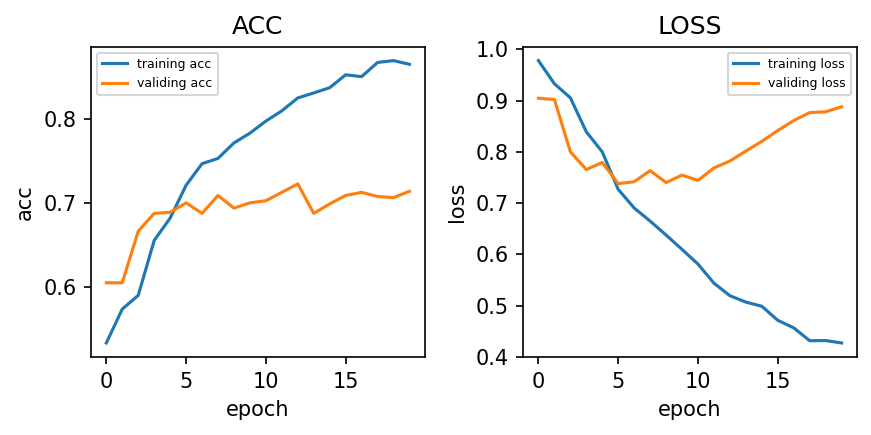

In [22]:
#文本+图片数据
train_data(only=None)

In [ ]:
#文本数据 （没有图片
train_data(only='text')

In [ ]:
#图片数据 （没有文本
train_data(only='img')